
# Functional → Anatomy → HCR Mapping (Zebrafish, 2P + HCR)

This notebook automates a practical pipeline to map motion-corrected functional planes to the best matching **2P anatomy** Z-plane and then into **HCR/confocal** space.

**Core steps**
1. Build a *crisp* per-plane functional reference using a Suite2p-style **top‑correlated mean**.
2. For each plane, find the **best matching Z** in the 2P anatomy stack via **normalized cross‑correlation**.
3. Estimate an **in‑plane transform** (shift/similarity) from functional reference → anatomy[best‑Z].
4. Apply a precomputed **3D warp** (anatomy → HCR) to place the functional plane/slab into HCR space.
5. Transfer **ROI labels** (nearest‑neighbor) or **fluorescence images** (linear) as appropriate.

> Tip: Set the voxel sizes (µm) correctly for both stacks before registration, and keep a record of transforms so you can compose and resample **once** wherever possible.



## Requirements

This notebook uses common scientific Python packages:

- `numpy`, `scipy`, `pandas`
- `tifffile`
- `scikit-image` (`skimage`)
- `opencv-python` (optional; speeds up template matching)
- `matplotlib` for quick QA plots

If an import fails, install the package in your environment and re-run the cell.


In [28]:

import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite, TiffFile
from skimage import filters, exposure, transform, feature, measure, registration, img_as_float32
from skimage.transform import SimilarityTransform, AffineTransform, warp
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

# Optional OpenCV (accelerated NCC); guarded import
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

import matplotlib.pyplot as plt

print("HAS_CV2:", HAS_CV2)


HAS_CV2: True



## Paths & I/O

Edit these to your data. You can also point to your colleague's helper notebook (`/mnt/data/fToA_registration_jl.ipynb`) if you want to copy functions from it.


In [ ]:

# --- Paths: legacy defaults ---
from pathlib import Path

LEGACY_FUNC_PATH = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/input/L395_f11_plane0_mcorrected_flipX_substack.tif')
LEGACY_ANAT_PATH = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/input/L395_f11_anatomy_2P_GCaMP.tif')

NAS_ROOT = Path('/Volumes/jlarsch/default/D2c/07_Data')
OWNER = 'Danin'
FISH_ID = 'L395_f11'
SINGLE_PLANE_MODE = True
KEEP_NATIVE_RESOLUTION = True
CONVERT_NRRD_TO_TIF = False
MAX_FRAMES_FOR_REF = 1000
LEGACY_REF_NORM_PATH = None
LEGACY_REF_RAW_PATH = None
TRUST_PREPROC_ORIENTATION = True
ANAT_FORCE_Z_FIRST = False
ANAT_SLICES_LAST = False
ANAT_ROT90_K = 0
ANAT_FLIP_X = False
ANAT_FLIP_Y = False
FUNC_FLIP_X = False  # set True only if the functional stack needs an X flip


def owner_root(nas_root, owner):
    base = nas_root / owner
    mic = base / 'Microscopy'
    return mic if mic.exists() else base

FISH_DIR = owner_root(NAS_ROOT, OWNER) / FISH_ID
ANALYSIS_DIR = FISH_DIR / '03_analysis'
OUTDIR = ANALYSIS_DIR / 'functional'
REF_DIR = OUTDIR / 'reference_planes'
REF_DIR.mkdir(parents=True, exist_ok=True)
OUTDIR.mkdir(exist_ok=True, parents=True)

TMP_CONVERT_DIR = OUTDIR / 'converted_nrrd_to_tif'
TMP_CONVERT_DIR.mkdir(parents=True, exist_ok=True)

def first_match(globs, desc):
    for g in globs:
        hits = list(FISH_DIR.glob(g))
        if hits:
            return hits[0]
    print(f"[WARN] No match for {desc} (patterns: {globs})")
    return None

FUNC_STACK_PATHS = [p for p in [LEGACY_FUNC_PATH] if p.exists()]
FUNC_STACK_PATH = FUNC_STACK_PATHS[0] if FUNC_STACK_PATHS else first_match([
    '02_reg/00_preprocessing/2p_functional/02_motionCorrected/*mcorrected*.tif'
], 'functional stack')

ANAT_STACK_PATH = LEGACY_ANAT_PATH if LEGACY_ANAT_PATH and LEGACY_ANAT_PATH.exists() else first_match([
    '02_reg/00_preprocessing/2p_anatomy/*_anatomy_2P_GCaMP.*'
], 'anatomy stack')
HCR_STACK_PATH = None

FUNC_LABEL_PATHS = sorted(FISH_DIR.glob('03_analysis/functional/cp_masks/*cp_masks.*'))
FUNC_LABELS_PATH = FUNC_LABEL_PATHS[0] if FUNC_LABEL_PATHS else first_match([
    f'03_analysis/functional/cp_masks/*{FISH_ID}*cp_masks.*',
], 'functional masks')
ANAT_LABELS_PATH = first_match([
    f'03_analysis/structural/cp_masks/*{FISH_ID}*cp_masks.*',
], 'anatomy/structural masks')

REF_BUILD_STRATEGY = globals().get('REF_BUILD_STRATEGY', 'time_mean')
RESCALE_FOR_NCC = False
VOX_FUNC_MANUAL = { 'X': 0.6166852, 'Y': 0.6166852 }
VOX_ANAT_MANUAL = { 'X': 0.5964025, 'Y': 0.5964025, 'Z': 2.0 }

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)



## Utility functions


In [30]:


def load_or_cache_voxels(path, tag=''):
    """Best-effort voxel size reader with optional JSON cache; returns dict like {'X': vx, 'Y': vy, 'Z': vz} in µm."""
    if not path:
        return {}
    p = Path(path)
    vox = {}
    cache_file = globals().get('VOX_CACHE_PATH', None)
    if cache_file:
        try:
            cache_file = Path(cache_file)
            if cache_file.exists():
                import json as _json
                data = _json.loads(cache_file.read_text())
                cached = data.get(str(p))
                if cached:
                    return cached
        except Exception:
            pass
    try:
        ext = p.suffix.lower()
        if ext in ('.tif', '.tiff'):
            from tifffile import TiffFile
            with TiffFile(str(p)) as tf:
                page = tf.pages[0]
                try:
                    resx = page.tags.get('XResolution')
                    resy = page.tags.get('YResolution')
                    if resx and resx.value[0]:
                        vox['X'] = float(resx.value[1]) / float(resx.value[0])
                    if resy and resy.value[0]:
                        vox['Y'] = float(resy.value[1]) / float(resy.value[0])
                except Exception:
                    pass
        elif ext == '.nrrd':
            try:
                import nrrd
                _, header = nrrd.read(str(p), return_header=True)
                dirs = header.get('space directions')
                if dirs is not None:
                    import numpy as _np
                    axes = ['X','Y','Z']
                    for i, ax in enumerate(axes):
                        if dirs[i] is not None:
                            vox[ax] = float(_np.linalg.norm(dirs[i])) * 1000.0
            except Exception:
                try:
                    import SimpleITK as sitk
                    img = sitk.ReadImage(str(p))
                    spacing = img.GetSpacing()
                    axes = ['X','Y','Z']
                    for ax, sp in zip(axes, spacing):
                        vox[ax] = float(sp) * 1000.0
                except Exception:
                    pass
    except Exception:
        pass
    if vox and cache_file:
        try:
            cache_file = Path(cache_file)
            cache_file.parent.mkdir(parents=True, exist_ok=True)
            import json as _json
            data = {}
            if cache_file.exists():
                data = _json.loads(cache_file.read_text())
            data[str(p)] = vox
            cache_file.write_text(_json.dumps(data, indent=2))
        except Exception:
            pass
    return vox

def imread_any(path):
    """Read tif/tiff or nrrd; fall back to tifffile for others. Requires `pynrrd` or `SimpleITK` for .nrrd files."""
    p = Path(path)
    ext = p.suffix.lower()
    if ext == '.nrrd':
        try:
            import nrrd
            data, _ = nrrd.read(str(p))
            return np.asarray(data)
        except Exception:
            try:
                import SimpleITK as sitk
                data = sitk.GetArrayFromImage(sitk.ReadImage(str(p)))
                return np.asarray(data)
            except Exception as e_sitk:
                raise ImportError("Reading .nrrd requires pynrrd or SimpleITK; pip install pynrrd or SimpleITK") from e_sitk
    return imread(path)

def maybe_convert_nrrd_to_tif(path, out_dir=None):
    """If path is .nrrd and CONVERT_NRRD_TO_TIF is True, convert to .tif in out_dir and return the new path."""
    if path is None:
        return None
    p = Path(path)
    if p.suffix.lower() != '.nrrd' or not globals().get('CONVERT_NRRD_TO_TIF', False):
        return p
    out_dir = out_dir or globals().get('TMP_CONVERT_DIR', None) or (Path('/tmp')/ '2pf_to_hcr_conversions')
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / (p.stem + '.tif')
    if (not out_path.exists()) or (out_path.stat().st_mtime < p.stat().st_mtime):
        data = imread_any(p)
        imwrite(out_path, data.astype(data.dtype))
        print(f"[INFO] Converted {p.name} -> {out_path}")
    return out_path

def quickshow(img, title=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def zproject_mean(stack):
    return stack.mean(axis=0)

def norm01(img):
    img = img.astype(np.float32)
    m, M = np.percentile(img, (1, 99))
    if M <= m:
        M = img.max(); m = img.min()
    out = np.clip((img - m) / (M - m + 1e-6), 0, 1)
    return out

def local_unsharp(img, blur_sigma=1.0, amount=0.6):
    base = ndi.gaussian_filter(img, blur_sigma)
    return np.clip(base + amount*(img - base), 0, 1)

def corrcoef_img(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am)*(b - bm)).sum()
    den = np.sqrt(((a - am)**2).sum() * ((b - bm)**2).sum()) + 1e-8
    return float(num / den)

def normxcorr2d(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    a = a - a.mean(); b = b - b.mean()
    num = (a*b).sum()
    den = np.sqrt((a*a).sum() * (b*b).sum()) + 1e-8
    return float(num/den)

def rescale_to_match(img, sy=1.0, sx=1.0):
    return transform.resize(img, (int(round(img.shape[0]*sy)), int(round(img.shape[1]*sx))), order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)

def estimate_inplane_transform(moving, fixed, method='similarity'):
    # crude feature-based estimate using phase correlation for shift, then fit transform
    from skimage.registration import phase_cross_correlation
    shift, _, _ = phase_cross_correlation(fixed, moving, upsample_factor=10)
    ty, tx = shift
    if method == 'similarity':
        tform = SimilarityTransform(translation=(-tx, -ty))
    else:
        tform = AffineTransform(translation=(-tx, -ty))
    return tform

def refine_affine_ecc(moving, fixed, init_tform=None, max_iters=200, eps=1e-6, pyr_levels=3):
    if init_tform is None:
        init_tform = SimilarityTransform()
    try:
        import cv2
        warp_mat = np.eye(2,3, dtype=np.float32)
        warp_mat[0,2] = init_tform.translation[0]
        warp_mat[1,2] = init_tform.translation[1]
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iters, eps)
        cc, warp_mat = cv2.findTransformECC(fixed.astype(np.float32), moving.astype(np.float32), warp_mat, cv2.MOTION_AFFINE, criteria, None, pyr_levels)
        return AffineTransform(matrix=np.vstack([warp_mat, [0,0,1]]))
    except Exception:
        return init_tform

def apply_transform_2d(img, tform, output_shape, order=1):
    return warp(img, inverse_map=tform.inverse, output_shape=output_shape, order=order, preserve_range=True, mode='reflect')

def resample_labels_nn(labels, tform, output_shape):
    return warp(labels, inverse_map=tform.inverse, output_shape=output_shape, order=0, preserve_range=True, mode='edge')

def _regionprops_centroids_2d(label_img):
    props = measure.regionprops(label_img.astype(int))
    import pandas as _pd
    rows = []
    for p in props:
        cy, cx = p.centroid
        rows.append({'label': p.label, 'cx': float(cx), 'cy': float(cy)})
    return _pd.DataFrame(rows)

def _apply_tform_points_xy(tform, xs, ys):
    pts = np.column_stack([xs, ys])
    pts_t = tform(pts)
    return pts_t[:,0], pts_t[:,1]

def center_crop_to_match(a, b):
    target_h = min(a.shape[0], b.shape[0])
    target_w = min(a.shape[1], b.shape[1])
    def _crop(img):
        h, w = img.shape[:2]
        sy = max((h - target_h)//2, 0); sx = max((w - target_w)//2, 0)
        return img[sy:sy+target_h, sx:sx+target_w]
    return _crop(a), _crop(b)

def top_correlated_mean(stack_t, take_k=20, pre_smooth_sigma=0.5):
    stack_t = stack_t.astype(np.float32)
    mean0 = stack_t.mean(axis=0)
    if pre_smooth_sigma:
        mean0 = ndi.gaussian_filter(mean0, pre_smooth_sigma)
    flat = stack_t.reshape(stack_t.shape[0], -1)
    mean_flat = mean0.ravel()
    cc = np.corrcoef(flat, mean_flat[None, :])
    corr_to_mean = cc[-1, :-1]
    idx = np.argsort(corr_to_mean)[-take_k:]
    return stack_t[idx].mean(axis=0)


def best_z_by_ncc(template, anat_stack, use_cv2=True):
    """Return best Z index and NCC scores over Z for a 2D template vs 3D stack."""
    template = norm01(template)
    scores = []
    if use_cv2 and HAS_CV2:
        templ8 = (template * 255).astype(np.uint8)
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            sl8 = (sl * 255).astype(np.uint8)
            res = cv2.matchTemplate(sl8, templ8, cv2.TM_CCORR_NORMED)
            s = float(res.max()) if res.size > 1 else float(res.ravel()[0])
            scores.append(s)
    else:
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            if sl.shape != template.shape:
                tmpl_c, sl_c = center_crop_to_match(template, sl)
            else:
                tmpl_c, sl_c = template, sl
            scores.append(corrcoef_img(tmpl_c, sl_c))
    scores = np.asarray(scores, dtype=np.float32)
    best_z = int(np.argmax(scores))
    return best_z, scores


In [31]:
# Infer and cache voxel sizes (µm) for func/anat[/HCR]
VOX_CACHE_PATH = OUTDIR / 'voxel_sizes.json'

# Detect from headers (fast, cached)
detF = load_or_cache_voxels(FUNC_STACK_PATH, 'func') if FUNC_STACK_PATH else {}
detA = load_or_cache_voxels(ANAT_STACK_PATH, 'anat') if ANAT_STACK_PATH else {}
detH = load_or_cache_voxels(HCR_STACK_PATH,  'hcr') if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else {}

# Start from detected values
VOX_FUNC = dict(detF or {})
VOX_ANAT = dict(detA or {})
VOX_HCR  = dict(detH or {}) if detH else None

# Manual overrides (fill per-axis if provided)
if isinstance(globals().get('VOX_FUNC_MANUAL', None), dict):
    for ax in ('X','Y','Z'):
        v = VOX_FUNC_MANUAL.get(ax)
        if v is not None:
            try: VOX_FUNC[ax] = float(v)
            except Exception: VOX_FUNC[ax] = v
if isinstance(globals().get('VOX_ANAT_MANUAL', None), dict):
    for ax in ('X','Y','Z'):
        v = VOX_ANAT_MANUAL.get(ax)
        if v is not None:
            try: VOX_ANAT[ax] = float(v)
            except Exception: VOX_ANAT[ax] = v

print('Voxel sizes (µm): func=', VOX_FUNC, 'anat=', VOX_ANAT, 'hcr=', VOX_HCR)

Voxel sizes (µm): func= {'X': 0.6166852, 'Y': 0.6166852} anat= {'X': 0.5964025, 'Y': 0.5964025, 'Z': 2.0} hcr= None



## 1) Build a crisp functional reference per plane

If your functional input is **single-plane over time**: this outputs one reference.  
If it's **volume over time**: set `PLANE_INDEX` to the plane you want, or loop planes.


[INFO] Found 5 cached functional references in /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/reference_planes; loading without reprocessing stacks.


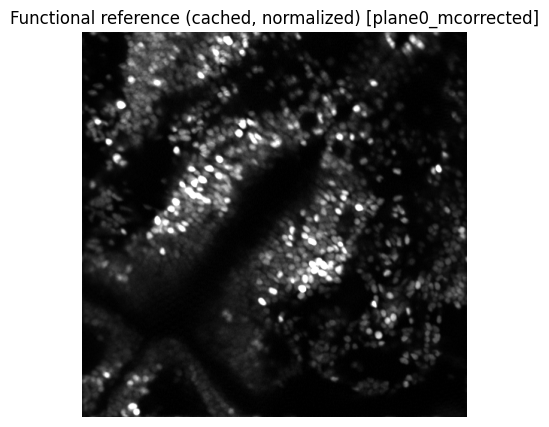

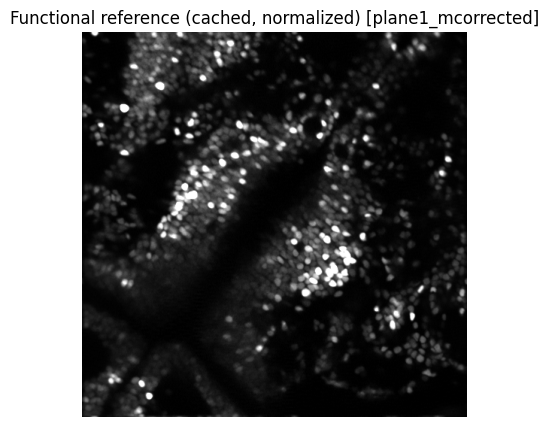

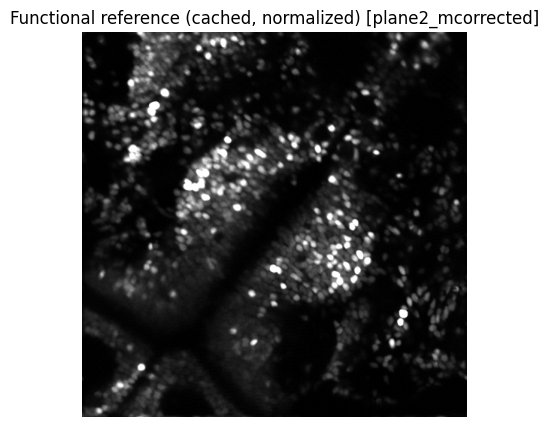

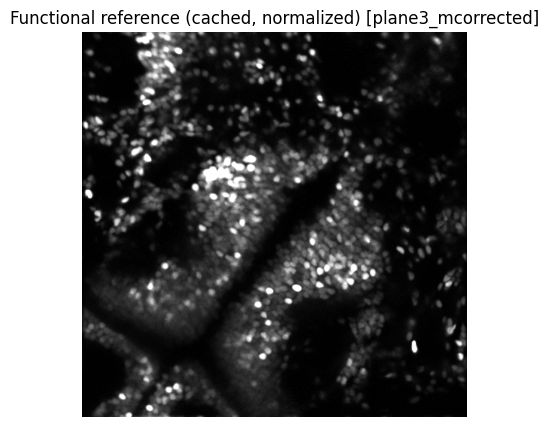

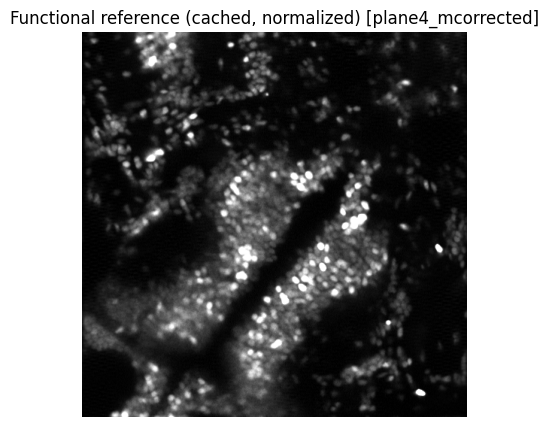

[INFO] SINGLE_PLANE_MODE=True: keeping first plane (plane0_mcorrected), discarding 4 others
Loaded 1 functional plane(s):
  - plane0_mcorrected: ref shape (512, 512)


In [32]:

# Load functional data (legacy-style single plane) and optional X flip

plane_refs = []
if LEGACY_REF_NORM_PATH:
    norm_path = Path(LEGACY_REF_NORM_PATH)
    raw_path = Path(LEGACY_REF_RAW_PATH) if LEGACY_REF_RAW_PATH else None
    if not norm_path.exists():
        raise FileNotFoundError(f"LEGACY_REF_NORM_PATH not found: {norm_path}")
    print(f"[INFO] Using legacy functional ref: {norm_path}")
    if raw_path:
        print(f"[INFO] Legacy functional raw: {raw_path}")
    norm_img = imread_any(norm_path)
    raw_img = imread_any(raw_path).astype(np.float32) if raw_path and raw_path.exists() else norm_img.astype(np.float32)
    lbl = norm_path.stem.replace(f"{FISH_ID}_", "")
    plane_refs.append({'label': lbl,'path': norm_path,'ref2d_raw': raw_img,'ref2d': norm01(raw_img)})
    quickshow(norm01(norm_img), f"Functional reference (legacy) [{lbl}]")
else:
    func_paths = []
    if FUNC_STACK_PATHS:
        func_paths = list(FUNC_STACK_PATHS)
    elif FUNC_STACK_PATH:
        func_paths = [FUNC_STACK_PATH]
    if not func_paths:
        raise FileNotFoundError('No functional stack found.')
    for idx, fpath in enumerate(func_paths):
        print(f"[INFO] Functional stack: {fpath}")
        arr = imread_any(fpath)
        if FUNC_FLIP_X:
            arr = arr[..., ::-1]
        max_frames = min(arr.shape[0], MAX_FRAMES_FOR_REF)
        if arr.ndim == 3:
            stack = arr[:max_frames]
            ref_raw = stack.mean(axis=0).astype(np.float32)
            ref = norm01(ref_raw)
            lbl = Path(fpath).stem if len(func_paths)>1 else f'plane{idx}'
            base = f"{FISH_ID}_{lbl}"
            imwrite(REF_DIR / f'{base}_time_mean_raw.tif', ref_raw.astype(np.float32))
            imwrite(REF_DIR / f'{base}_time_mean_norm_for_matching.tif', (ref*65535).astype(np.uint16))
            plane_refs.append({'label': lbl,'path': fpath,'ref2d_raw': ref_raw,'ref2d': ref,'index': idx})
            quickshow(ref, f"Functional reference (normalized) [{lbl}]")
        else:
            print(f"[WARN] Unsupported functional stack shape {arr.shape} in {fpath}; skipping")
            continue

if SINGLE_PLANE_MODE and len(plane_refs)>1:
    plane_refs = plane_refs[:1]

if not plane_refs:
    raise RuntimeError('No usable functional planes found after loading/flipping.')

print(f"Loaded {len(plane_refs)} functional plane(s):")
for pr in plane_refs:
    print(f"  - {pr['label']}: ref shape {pr['ref2d'].shape}, source={pr['path']}")

ref2d_raw = plane_refs[0]['ref2d_raw']
ref2d = plane_refs[0]['ref2d']


In [ ]:

# 1.5) Convert anatomy NRRD to TIFF (reorder to Z,X,Y) and use it
if ANAT_STACK_PATH.suffix.lower() == '.nrrd':
    nrrd_path = ANAT_STACK_PATH
    try:
        import nrrd
        data, _ = nrrd.read(str(nrrd_path))
    except Exception:
        try:
            import SimpleITK as sitk
            data = sitk.GetArrayFromImage(sitk.ReadImage(str(nrrd_path)))
        except Exception as e:
            raise e
    print("NRRD anatomy shape (as read):", data.shape)
    if data.ndim == 3 and data.shape[-1] < min(data.shape[0], data.shape[1]):
        data = data.transpose(2, 1, 0)
        print("Reordered anatomy to (Z, X, Y):", data.shape)
    out_conv = OUTDIR / f"{FISH_ID}_anatomy_converted.tif"
    imwrite(out_conv, data.astype(data.dtype))
    ANAT_STACK_PATH = out_conv
    print(f"[INFO] Converted anatomy to {out_conv} and set ANAT_STACK_PATH")
else:
    print(f"[INFO] Anatomy is not NRRD ({ANAT_STACK_PATH.suffix}); skipping conversion")



## 2) Find the best matching Z in the 2P anatomy stack
We correlate the functional reference against each anatomy slice and take the Z with the maximum NCC.


In [33]:
print(f"[INFO] Anatomy stack: {ANAT_STACK_PATH}")
anat = imread_any(ANAT_STACK_PATH)
print("Anatomy shape (as read):", anat.shape)

# Pre-filter anatomy and build matchable reference(s)
anat_f = np.stack([local_unsharp(norm01(s), 1.0, 0.6) for s in anat], axis=0)

# Keep native ref size by default (sliding NCC); set FORCE_REF_RESIZE=True to resize ref→anat shape
FORCE_REF_RESIZE = globals().get('FORCE_REF_RESIZE', False)

for pr in plane_refs:
    ref_match = local_unsharp(norm01(pr['ref2d_raw']), 1.0, 0.6)
    # Optional voxel-based rescale before matching
    if RESCALE_FOR_NCC:
        try:
            if 'VOX_FUNC' in globals() and 'VOX_ANAT' in globals() and VOX_FUNC and VOX_ANAT:
                sy = float(VOX_FUNC.get('Y', 1.0)) / float(VOX_ANAT.get('Y', 1.0))
                sx = float(VOX_FUNC.get('X', 1.0)) / float(VOX_ANAT.get('X', 1.0))
                print(f"Rescale for NCC [{pr['label']}]: sy={sy:.4f}, sx={sx:.4f}, ref shape {ref_match.shape}")
                ref_match = rescale_to_match(ref_match, sy=sy, sx=sx)
                print(f"→ Rescaled ref shape {ref_match.shape}")
        except Exception as _e:
            print('Warning: voxel-based rescale skipped:', _e)
    # Size handling
    if ref_match.shape != anat_f[0].shape:
        if FORCE_REF_RESIZE:
            print(f"[WARN] Ref/anat shape mismatch for {pr['label']}: {ref_match.shape} vs {anat_f[0].shape}; resizing ref for NCC")
            ref_match = transform.resize(ref_match, anat_f[0].shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
        else:
            print(f"[INFO] Using ref shape {ref_match.shape} vs anat {anat_f[0].shape}; matcher will slide template")
    best_z, scores = best_z_by_ncc(ref_match, anat_f, use_cv2=HAS_CV2)
    pr['ref_match'] = ref_match
    pr['ncc_scores'] = scores
    pr['best_z'] = best_z
    print(f"[{pr['label']}] best Z (current anatomy) = {best_z}")

best_z = plane_refs[0]['best_z']
ref_match = plane_refs[0]['ref_match']


[INFO] Converted L395_f11_anatomy_2P_GCaMP.nrrd -> /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/converted_nrrd_to_tif/L395_f11_anatomy_2P_GCaMP.tif
Legacy anatomy shape (as read): (216, 750, 750)
Anatomy shape (as read): (750, 750, 216)
Moved current anatomy slices to first axis -> (216, 750, 750)
Moved legacy anatomy slices to first axis -> (750, 216, 750)
Applied rotation k=1 in YX plane
Applied ANAT_FLIP_Y
Anatomy shape (after orientation handling): (216, 750, 750)
Legacy anatomy shape (after orientation handling): (750, 750, 216)
[INFO] Saved converted anatomy to /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/converted_nrrd_to_tif/L395_f11_anat_current_converted.tif
[plane0_mcorrected] best Z (current anatomy) = 122
[plane0_mcorrected] best Z (legacy anatomy) = 404



## 3) Estimate in-plane transform (functional → anatomy[best‑Z])
We try ORB+RANSAC to get a **similarity** (shift/scale/rotation) transform, and fall back to phase correlation (shift only).



## Compare functional projections (normalized vs raw)

Side-by-side view to sanity-check normalization effects before overlay.

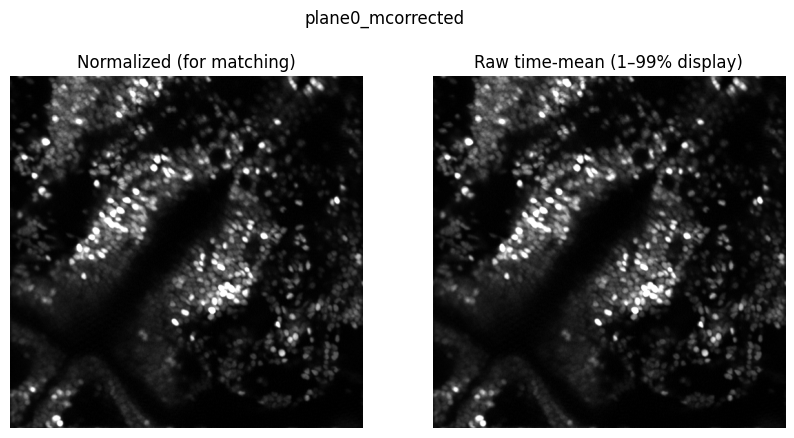

In [35]:

# Compare normalized reference (ref2d) and non-normalized mean (ref2d_raw) for each plane
import numpy as _np
import matplotlib.pyplot as _plt

for pr in plane_refs:
    ref = pr['ref2d']; raw = pr['ref2d_raw']
    vmin, vmax = _np.percentile(raw.astype(_np.float32), (1,99))
    _plt.figure(figsize=(10,5))
    _plt.suptitle(f"{pr['label']}")
    _plt.subplot(1,2,1); _plt.imshow(ref, cmap='gray', vmin=0, vmax=1); _plt.title('Normalized (for matching)'); _plt.axis('off')
    _plt.subplot(1,2,2); _plt.imshow(raw, cmap='gray', vmin=vmin, vmax=vmax); _plt.title('Raw time-mean (1–99% display)'); _plt.axis('off')
    _plt.show()


In [36]:

# Estimate in-plane transform per plane and warp for QA

tforms = []
for pr in plane_refs:
    bz = pr['best_z']
    a_slice = anat_f[bz]
    ref_match = pr['ref_match']
    if ref_match.shape != a_slice.shape:
        print(f"[WARN] Ref/anat shape mismatch for transform {pr['label']}: {ref_match.shape} vs {a_slice.shape}; resizing ref for transform")
        ref_match = transform.resize(ref_match, a_slice.shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
    tform_sim = estimate_inplane_transform(ref_match, a_slice, method='similarity')
    tform_aff = estimate_inplane_transform(ref_match, a_slice, method='affine')
    tform = refine_affine_ecc(ref_match, a_slice, init_tform=tform_aff, max_iters=300, eps=1e-6, pyr_levels=3)
    pr['tform_sim'] = tform_sim
    pr['tform_aff'] = tform_aff
    pr['tform'] = tform
    pr['ref_warped_raw'] = apply_transform_2d(pr['ref2d_raw'], tform, output_shape=a_slice.shape, order=1)
    pr['ref_warped'] = norm01(pr['ref_warped_raw'])
    quickshow(pr['ref_warped'], f"{pr['label']} warped into anatomy (norm)")
    print(f"[{pr['label']}] Similarity params:
{tform_sim.params}
Affine params:
{tform.params}")

# Convenience globals for downstream overlays (use first plane)
tform = plane_refs[0]['tform']
ref_warped_raw = plane_refs[0]['ref_warped_raw']
ref_warped = plane_refs[0]['ref_warped']


SyntaxError: unterminated string literal (detected at line 23) (3345078488.py, line 23)

In [ ]:

# Interactive overlay: toggle channels like FIJI (per plane)
try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception as _e:
    _HAS_WIDGETS = False
    print('ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.')

if not plane_refs:
    __overlay_ready = False
    print('No plane_refs available; run previous cells.')
else:
    __overlay_ready = True

_COLORS = {
    'green':   (0.0, 1.0, 0.0),
    'magenta': (1.0, 0.0, 1.0),
    'red':     (1.0, 0.0, 0.0),
    'blue':    (0.0, 0.0, 1.0),
    'cyan':    (0.0, 1.0, 1.0),
    'yellow':  (1.0, 1.0, 0.0),
    'white':   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01*r, gray01*g, gray01*b], axis=-1)

def _make_overlay(pr, func_color='green', anat_color='magenta', func_alpha=1.0, anat_alpha=1.0, show_func=True, show_anat=True):
    bz = pr['best_z']
    # Prefer warped functional reference if available; else compute a preview using the current transform; else fall back.
    if pr.get('ref_warped') is not None:
        f_src = pr['ref_warped']; src_label = 'warped'
    elif pr.get('tform') is not None:
        mov_src = pr.get('ref_match', pr.get('ref2d_raw', pr.get('ref2d')))
        f_src = apply_transform_2d(mov_src, pr['tform'], output_shape=anat[bz].shape, order=1); src_label = 'tform-preview'
    else:
        f_src = pr['ref2d']; src_label = 'raw'
    f_vis = norm01(f_src)
    a_vis = norm01(anat[bz])
    if f_vis.shape != a_vis.shape:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
    out = np.zeros((f_vis.shape[0], f_vis.shape[1], 3), dtype=np.float32)
    if show_anat:
        out += _apply_color(a_vis, _COLORS[anat_color]) * float(anat_alpha)
    if show_func:
        out += _apply_color(f_vis, _COLORS[func_color]) * float(func_alpha)
    out = np.clip(out, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title(f"Overlay [{pr['label']}] — func[{func_color}] α={func_alpha:.2f}, anat[{anat_color}] α={anat_alpha:.2f} | func src: {src_label} | best_z={bz}")
    plt.axis('off')
    plt.show()

if _HAS_WIDGETS and __overlay_ready:
    plane_dd = widgets.Dropdown(options=[(pr['label'], i) for i, pr in enumerate(plane_refs)], value=0, description='Plane')
    show_func_cb = widgets.Checkbox(value=True, description='Show functional')
    show_anat_cb = widgets.Checkbox(value=True, description='Show anatomy')
    func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='green', description='Func LUT')
    anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='magenta', description='Anat LUT')
    func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Func α')
    anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Anat α')
    def _render(plane_idx, show_func, show_anat, func_color, anat_color, func_alpha, anat_alpha):
        pr = plane_refs[int(plane_idx)]
        _make_overlay(pr, func_color=func_color, anat_color=anat_color, func_alpha=func_alpha, anat_alpha=anat_alpha, show_func=show_func, show_anat=show_anat)
    ui = widgets.VBox([
        plane_dd,
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl])
    ])
    out = widgets.interactive_output(_render, {
        'plane_idx': plane_dd,
        'show_func': show_func_cb,
        'show_anat': show_anat_cb,
        'func_color': func_color_dd,
        'anat_color': anat_color_dd,
        'func_alpha': func_alpha_sl,
        'anat_alpha': anat_alpha_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print('Interactive overlay not shown: run previous cells first.')
else:
    # Fallback: render a static overlay for each plane
    for pr in plane_refs:
        _make_overlay(pr)



## 3.0) Mask diameters by axis (µm)
Assess label diameters along Z, Y, X for functional, anatomy, and HCR masks.

In [ ]:

# Mask diameters (µm) for anatomy, functional, HCR (if available)
import numpy as _np, matplotlib.pyplot as _plt

def _load_labels_or_none(path):
    if path is None:
        return None
    try:
        if not os.path.exists(path):
            return None
        arr = _ensure_uint_labels(imread(path))
        if arr.ndim == 3 and arr.shape[-1] in (3,4):
            arr = arr[...,0]
        return arr
    except Exception as _e:
        print('Could not load labels from', path, ':', _e)
        return None

dfs = []
anat_labels = _load_labels_or_none(ANAT_LABELS_PATH)
if anat_labels is not None:
    anat_3d = anat_labels if anat_labels.ndim == 3 else anat_labels[None, ...]
    vox_a = {
        'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
    }
    df_anat_diam = diameters_um_from_array(anat_3d, vox_a)
    df_anat_diam['dataset'] = 'Anatomy'
    dfs.append(df_anat_diam)

func_labels = _load_labels_or_none(FUNC_LABELS_PATH)
if func_labels is not None:
    func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
    vox_f = {
        'Z': 1.0,
        'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
    }
    df_func_diam = diameters_um_from_array(func_3d, vox_f)
    df_func_diam['dataset'] = 'Functional'
    dfs.append(df_func_diam)

HCR_LABELS_PATH = globals().get('HCR_LABELS_PATH', None)
hcr_labels = _load_labels_or_none(HCR_LABELS_PATH) if HCR_LABELS_PATH is not None else None
if hcr_labels is not None:
    hcr_3d = hcr_labels if hcr_labels.ndim == 3 else hcr_labels[None, ...]
    vox_h = {
        'Z': float(VOX_HCR.get('Z',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'Y': float(VOX_HCR.get('Y',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'X': float(VOX_HCR.get('X',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
    }
    df_hcr_diam = diameters_um_from_array(hcr_3d, vox_h)
    df_hcr_diam['dataset'] = 'HCR'
    dfs.append(df_hcr_diam)

if not dfs:
    print('No label volumes available for diameter analysis.')
else:
    df_all = pd.concat(dfs, ignore_index=True)
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all['dataset'].unique()]

    def _series_for_axis(axis_col):
        ser = []
        for ds in present:
            vals = df_all.loc[df_all['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um')
    series_y = _series_for_axis('y_um')
    series_z = _series_for_axis('z_um')

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any(
        (a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    for ax, ser, title in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)']):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = 'median={:.2f} µm\nn={:d}'.format(med, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle('Mask diameters by axis — Anatomy, Functional, HCR')
    _plt.tight_layout()
    _plt.show()

    rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            rows.append({'dataset': ds, 'x_median': _np.nan, 'y_median': _np.nan, 'z_median': _np.nan, 'n': 0})
        else:
            rows.append({
                'dataset': ds,
                'x_median': float(_np.median(sub['x_um'])) if len(sub['x_um']) else _np.nan,
                'y_median': float(_np.median(sub['y_um'])) if len(sub['y_um']) else _np.nan,
                'z_median': float(_np.median(sub['z_um'])) if len(sub['z_um']) else _np.nan,
                'n': int(len(sub)),
            })
    med_table = pd.DataFrame(rows)
    try:
        display(med_table)
    except Exception:
        print(med_table.to_string(index=False))


## 3.1) Transfer functional labels to anatomy (nearest-neighbor)
Warp the functional label image (`FUNC_LABELS_PATH`) into anatomy slice space using the in-plane transform (`tform`, `best_z`), save it, and then run QA on the saved result.


In [ ]:

import re
from pathlib import Path as _Path

FUNC_LABELS_IN_ANAT_MAP = {}
labels_out_dir = ANALYSIS_DIR / 'functional' / 'labels_in_anat'
labels_out_dir.mkdir(parents=True, exist_ok=True)

if not plane_refs:
    print('No planes loaded; run functional loading first.')
else:
    def _pick_label_path(pr):
        # Try a direct match to plane label in filename; fall back to first available
        candidates = []
        if 'FUNC_LABEL_PATHS' in globals() and FUNC_LABEL_PATHS:
            candidates.extend(FUNC_LABEL_PATHS)
        if FUNC_LABELS_PATH and FUNC_LABELS_PATH not in candidates:
            candidates.append(FUNC_LABELS_PATH)
        lbl_lower = pr['label'].lower()
        for p in candidates:
            name = p.name.lower()
            if lbl_lower in name:
                return p
            m = re.search(r'plane(\d+)', name)
            if m and f"plane{m.group(1)}" in lbl_lower:
                return p
        return candidates[0] if candidates else None

    def warp_labels_for_plane(plane_idx):
        pr = plane_refs[int(plane_idx)]
        lbl_path = _pick_label_path(pr)
        if lbl_path is None or not os.path.exists(lbl_path):
            print(f"[WARN] No functional label file found for plane {pr['label']}")
            return None
        if pr.get('tform') is None:
            print(f"[WARN] No in-plane transform for plane {pr['label']}; run alignment first.")
            return None
        labels = imread_any(lbl_path)
        if labels.ndim == 3:
            labels = labels[..., 0]
        labels_warp = resample_labels_nn(labels, pr['tform'], output_shape=anat.shape[1:])
        out_path = labels_out_dir / f"{FISH_ID}_{pr['label']}_labels_in_anat.tif"
        imwrite(out_path, labels_warp.astype(np.uint16))
        FUNC_LABELS_IN_ANAT_MAP[pr['label']] = out_path
        print(f"Saved {out_path}")
        quickshow(labels_warp > 0, f"Labels in anatomy space (any>0) [{pr['label']}]")
        return out_path

    try:
        import ipywidgets as widgets
        from IPython.display import display
        plane_dd = widgets.Dropdown(options=[(pr['label'], i) for i, pr in enumerate(plane_refs)], value=0, description='Plane')
        warp_btn = widgets.Button(description='Warp labels', button_style='success')
        out = widgets.Output()
        def _on_click(_):
            with out:
                out.clear_output(wait=True)
                warp_labels_for_plane(plane_dd.value)
        warp_btn.on_click(_on_click)
        display(widgets.HBox([plane_dd, warp_btn]), out)
    except Exception:
        print('ipywidgets not available; warping all planes once.')
        for i in range(len(plane_refs)):
            warp_labels_for_plane(i)


## 3.1a) Centroid distance QA (labels already in anatomy space)
Violin plot and overlay using functional labels that have been warped into anatomy space. Use the slider to see how many cells remain under a distance threshold.


In [ ]:

import re

links_cache = {}

if not plane_refs:
    print('No planes available; run previous steps.')
else:
    def _pick_label_path(pr):
        paths = []
        if 'FUNC_LABELS_IN_ANAT_MAP' in globals():
            maybe = FUNC_LABELS_IN_ANAT_MAP.get(pr['label'])
            if maybe:
                paths.append(Path(maybe))
        if 'FUNC_LABEL_PATHS' in globals() and FUNC_LABEL_PATHS:
            paths.extend(FUNC_LABEL_PATHS)
        if 'FUNC_LABELS_PATH' in globals() and FUNC_LABELS_PATH:
            paths.append(FUNC_LABELS_PATH)
        lbl_lower = pr['label'].lower()
        for p in paths:
            name = p.name.lower()
            if p.exists() and lbl_lower in name:
                return p
            m = re.search(r'plane(\d+)', name)
            if m and f"plane{m.group(1)}" in lbl_lower and p.exists():
                return p
        for p in paths:
            if hasattr(p, 'exists') and p.exists():
                return p
        return None

    def _load_func_labels_in_anat(pr):
        # Try saved warp first
        if 'FUNC_LABELS_IN_ANAT_MAP' in globals():
            maybe = FUNC_LABELS_IN_ANAT_MAP.get(pr['label'])
            if maybe and os.path.exists(maybe):
                fl = _ensure_uint_labels(imread(maybe))
                if fl.ndim == 3:
                    fl = fl[...,0]
                return fl
        lbl_path = _pick_label_path(pr)
        if lbl_path is None or not os.path.exists(lbl_path):
            print(f"[WARN] No functional label file for plane {pr['label']}")
            return None
        if pr.get('tform') is None:
            print(f"[WARN] No in-plane transform for plane {pr['label']}; cannot warp labels.")
            return None
        labels = imread(lbl_path)
        if labels.ndim == 3:
            labels = labels[...,0]
        return resample_labels_nn(labels, pr['tform'], output_shape=anat.shape[1:])

    def _compute_links(pr):
        func_labels = _load_func_labels_in_anat(pr)
        if func_labels is None:
            return None
        anat_labels = None
        if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
            anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
        if anat_labels is None:
            print('Missing ANAT_LABELS_PATH; cannot run centroid QA.')
            return None
        bz = pr['best_z']
        anat_labels_z = anat_labels[int(bz)] if anat_labels.ndim==3 else anat_labels
        fdf = _regionprops_centroids_2d(func_labels)
        adf = _regionprops_centroids_2d(anat_labels_z)
        F = fdf[['cx','cy']].to_numpy(); A = adf[['cx','cy']].to_numpy()
        d2 = ((F[:,None,:] - A[None,:,:])**2).sum(axis=2); D = np.sqrt(d2)
        from scipy.optimize import linear_sum_assignment as _lsa
        row_ind, col_ind = _lsa(D)
        MAX_LINK_DIST_PX = 50.0
        keep = D[row_ind, col_ind] <= MAX_LINK_DIST_PX
        row_ind = row_ind[keep]; col_ind = col_ind[keep]
        try:
            vox_x = float(VOX_ANAT.get('X', VOX_ANAT.get(2, VOX_ANAT.get('2', 1.0))))
            vox_y = float(VOX_ANAT.get('Y', VOX_ANAT.get(1, VOX_ANAT.get('1', 1.0))))
        except Exception:
            vox_x, vox_y = 1.0, 1.0
        links = []
        for r, c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c])
            dx_um = (fxp - axp) * vox_x; dy_um = (fyp - ayp) * vox_y
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({'fx_anat_px': fxp, 'fy_anat_px': fyp, 'ax_px': axp, 'ay_px': ayp, 'dist_px': dist_px, 'dist_um': dist_um})
        import pandas as _pd
        df = _pd.DataFrame(links)
        if len(df):
            df.to_csv(OUTDIR / f"f2a_centroid_matches_{pr['label']}.csv", index=False)
        return df

    try:
        import ipywidgets as widgets
        from IPython.display import display
        plane_dd = widgets.Dropdown(options=[(pr['label'], i) for i, pr in enumerate(plane_refs)], value=0, description='Plane')
        thr_sl = widgets.FloatSlider(value=5.0, min=0.0, max=50.0, step=0.5, description='Threshold (µm)')
        count_html = widgets.HTML()
        def _render(plane_idx, threshold):
            pr = plane_refs[int(plane_idx)]
            df = links_cache.get(pr['label'])
            if df is None:
                df = _compute_links(pr)
                links_cache[pr['label']] = df
            if df is None or not len(df):
                print(f"No centroid matches to plot for {pr['label']}")
                return
            d = df['dist_um'].to_numpy().astype(float)
            import numpy as _np, matplotlib.pyplot as _plt
            N = int(d.size); med = float(_np.median(d))
            try:
                bg = norm01(anat[int(pr['best_z'])])
            except Exception:
                bg = None
            keep_mask = d <= float(threshold); keep = int(keep_mask.sum())
            fig, (ax1, ax2) = _plt.subplots(1,2, figsize=(16,7), gridspec_kw={'width_ratios':[1,3]})
            vp = ax1.violinplot(d, showmeans=False, showmedians=False, showextrema=False)
            for pc in vp['bodies']:
                pc.set_facecolor('#88ccee'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
            ax1.axhline(med, color='crimson', linestyle='--', linewidth=1.5, label=f"Median {med:.2f} µm")
            ax1.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f"Thresh {threshold:.2f} µm")
            ax1.set_xticks([]); ax1.set_ylabel('Centroid distance (µm)'); ax1.set_title(f"Centroid distances (µm) — {pr['label']}"); ax1.legend(loc='lower right')
            if bg is not None: ax2.imshow(bg, cmap='gray')
            kept = df[keep_mask] if keep_mask.shape[0] == len(df) else df
            if keep and all(col in kept.columns for col in ('ax_px','ay_px','fx_anat_px','fy_anat_px')):
                ax2.scatter(kept['ax_px'], kept['ay_px'], s=30, c='magenta', label='Anat centroids')
                ax2.scatter(kept['fx_anat_px'], kept['fy_anat_px'], s=30, facecolors='none', edgecolors='lime', label='Func→Anat centroids')
                for _, row in kept.iterrows():
                    ax2.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
                ax2.legend(loc='lower right')
            ax2.set_title(f"Kept links (≤ {float(threshold):.2f} µm) on anatomy — {pr['label']}"); ax2.axis('off'); _plt.tight_layout(); _plt.show()
            count_html.value = f"<b>Keep:</b> {keep} / {N} cells (≤ {float(threshold):.2f} µm)"
        ctrl = widgets.interactive_output(_render, {'plane_idx': plane_dd, 'threshold': thr_sl})
        display(widgets.VBox([plane_dd, thr_sl, count_html, ctrl]))
        _render(plane_dd.value, thr_sl.value)
    except Exception as _e:
        print('ipywidgets not available; running QA for all planes (static).', _e)
        for pr in plane_refs:
            df = links_cache.get(pr['label']) or _compute_links(pr)
            links_cache[pr['label']] = df
            if df is None or not len(df):
                print(f"No centroid matches to plot for {pr['label']}")
                continue
            d = df['dist_um'].to_numpy().astype(float)
            import numpy as _np, matplotlib.pyplot as _plt
            med = float(_np.median(d))
            keep_mask = d <= 5.0
            fig, (ax1, ax2) = _plt.subplots(1,2, figsize=(16,7), gridspec_kw={'width_ratios':[1,3]})
            vp = ax1.violinplot(d, showmeans=False, showmedians=False, showextrema=False)
            for pc in vp['bodies']:
                pc.set_facecolor('#88ccee'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
            ax1.axhline(med, color='crimson', linestyle='--', linewidth=1.5)
            ax1.axhline(5.0, color='orange', linestyle=':', linewidth=1.5)
            ax1.set_xticks([]); ax1.set_ylabel('Centroid distance (µm)'); ax1.set_title(f"Centroid distances (µm) — {pr['label']}")
            try:
                bg = norm01(anat[int(pr['best_z'])]); ax2.imshow(bg, cmap='gray')
            except Exception:
                pass
            kept = df[keep_mask] if keep_mask.shape[0] == len(df) else df
            if all(col in kept.columns for col in ('ax_px','ay_px','fx_anat_px','fy_anat_px')):
                ax2.scatter(kept['ax_px'], kept['ay_px'], s=30, c='magenta')
                ax2.scatter(kept['fx_anat_px'], kept['fy_anat_px'], s=30, facecolors='none', edgecolors='lime')
                for _, row in kept.iterrows():
                    ax2.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
            ax2.set_title(f"Kept links (≤5 µm) on anatomy — {pr['label']}"); ax2.axis('off'); _plt.tight_layout(); _plt.show()



## 3.2) 3D viewer for anatomy with overlays
Scroll Z, toggle overlays (anatomy labels, warped functional labels, and centroids).


In [ ]:

try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_W = True
except Exception:
    _HAS_W = False
    print('ipywidgets not available; skipping 3D viewer.')

if _HAS_W and 'anat' in globals():
    Z = anat.shape[0] if anat.ndim == 3 else 1
    z_sl = widgets.IntSlider(value=int(best_z) if 'best_z' in globals() else 0, min=0, max=max(0,Z-1), step=1, description='Z')
    show_anat_lbl = widgets.Checkbox(value=True, description='Show anatomy labels')
    show_func_lbl = widgets.Checkbox(value=os.path.exists(OUTDIR/'func_labels_in_anat_slice.tif'), description='Show func labels (warped)')
    show_centroids = widgets.Checkbox(value=True, description='Show centroids')
    alpha_lbl = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.05, description='Label α')

    # Load for viewer (lazy)
    _anat_labels = None
    if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
        _anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
    _func_warp = None
    fw_path = OUTDIR/'func_labels_in_anat_slice.tif'
    if os.path.exists(fw_path):
        _func_warp = _ensure_uint_labels(imread(fw_path))

    def _draw(z, show_al, show_fl, show_pts, alpha):
        sl = anat[z] if anat.ndim == 3 else anat
        plt.figure(figsize=(6,6))
        plt.imshow(norm01(sl), cmap='gray')
        if show_al and _anat_labels is not None:
            if _anat_labels.ndim == 3:
                al = _anat_labels[z]
            else:
                al = _anat_labels
            plt.imshow(al, cmap='nipy_spectral', alpha=alpha, interpolation='nearest')
        if show_fl and _func_warp is not None and z == int(best_z):
            plt.imshow(_func_warp, cmap='viridis', alpha=alpha, interpolation='nearest')
        if show_pts and os.path.exists(OUTDIR/'f2a_centroid_matches.csv') and z == int(best_z):
            df = pd.read_csv(OUTDIR/'f2a_centroid_matches.csv')
            if len(df):
                plt.scatter(df['ax_px'], df['ay_px'], s=25, c='magenta', label='Anat c')
                plt.scatter(df['fx_anat_px'], df['fy_anat_px'], s=25, facecolors='none', edgecolors='lime', label='Func→Anat c')
        plt.title(f'Anatomy Z={z}')
        plt.axis('off'); plt.show()

    out = widgets.interactive_output(_draw, {
        'z': z_sl, 'show_al': show_anat_lbl, 'show_fl': show_func_lbl, 'show_pts': show_centroids, 'alpha': alpha_lbl
    })
    ui = widgets.VBox([z_sl, widgets.HBox([show_anat_lbl, show_func_lbl, show_centroids, alpha_lbl])])
    display(ui, out)
else:
    print('3D viewer prerequisites missing (anat, ipywidgets).')



## 5) Apply anatomy → HCR 3D warp (hook)

Provide a function `warp3d_func(slice_img, z_index)` that applies your 3D deformation field to a 2D slice at Z.  
This is where you plug in BigWarp/ANTs/SimpleITK. Below is a **mock** that passes data through unchanged.


## Confocal masks via `best_rounds.csv` (ANTs transforms)

We now handle multi-round confocal the same way as antsQC: pick the best confocal round, register it to 2P, and send other rounds through rX->best->2P. Metadata lives at `/Volumes/jlarsch/default/D2c/07_Data/Danin/best_rounds.csv` with columns `fish_id,best_round,num_rounds,owner`. Masks are expected under `03_analysis/confocal/masks/*round{n}*_cp_masks.tif`; outputs go to `.../aligned/*_in_2p.<ext>`. Transforms are discovered under `02_reg/**/transMatrices/` and ordered for `antsApplyTransforms` as `[best->2p warp, best->2p affine, rX->best warp, rX->best affine]` (omit the rX->best pair for the best round). Reference grid: `02_reg/00_preprocessing/2p_anatomy/<fish>_anatomy_2P_GCaMP.nrrd`. After building the manifest, run `python applyTransform.py --mode manifest --manifest-csv /Volumes/jlarsch/default/D2c/07_Data/Danin/confocal_mask_manifest.csv --force` (set interpolator to nearestNeighbor for label masks). If mask filenames differ (e.g., Cellpose outputs), populate `HARDCODED_MASKS` in the code cell below to override the glob per fish/round; outputs will retain the input extension.


In [ ]:
from pathlib import Path
import pandas as pd

BEST_ROUNDS_CSV = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/best_rounds.csv")
NAS_ROOT = Path("/Volumes/jlarsch/default/D2c/07_Data")
MANIFEST_OUT = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/confocal_mask_manifest.csv")
MASK_GLOB = "03_analysis/confocal/masks/*round{round_idx}*_cp_masks.tif"
# Override per fish/round if filenames differ (e.g., Cellpose). Example structure:
# HARDCODED_MASKS = {
#     "L395_f11": {
#         1: ["/path/to/L395_f11_round1_mask.tif"],
#         2: ["/path/to/L395_f11_round2_mask.nrrd"],
#     }
# }
HARDCODED_MASKS = {}

def owner_root(nas_root, owner):
    base = Path(nas_root) / owner
    mic = base / "Microscopy"
    return mic if mic.exists() else base

def find_transform_pair(fish_dir, src_round, target_tags):
    tm_root = fish_dir / "02_reg"
    candidates = sorted(tm_root.glob("**/transMatrices/*"), key=lambda p: p.stat().st_mtime, reverse=True)
    src_token = f"round{src_round}"
    warp = affine = None
    for f in candidates:
        name = f.name.lower()
        if src_token not in name:
            continue
        if not any(tag in name for tag in target_tags):
            continue
        if "inverse" in name:
            continue
        if ("warp" in name) and name.endswith(".nii.gz") and warp is None:
            warp = f
        if ("affine" in name) and f.suffix == ".mat" and affine is None:
            affine = f
        if warp and affine:
            break
    return warp, affine

def build_manifest_rows(best_row):
    fish_id = str(best_row.fish_id)
    best_round = str(best_row.best_round).lower()
    best_idx = int(best_round.lstrip("r"))
    num_rounds = int(best_row.num_rounds)
    owner = str(best_row.owner)
    fish_dir = owner_root(NAS_ROOT, owner) / fish_id
    ref = fish_dir / "02_reg" / "00_preprocessing" / "2p_anatomy" / f"{fish_id}_anatomy_2P_GCaMP.nrrd"
    if not ref.exists():
        print(f"[WARN] Missing 2P anatomy for {fish_id}")
        return []
    best2p_warp, best2p_aff = find_transform_pair(fish_dir, best_idx, target_tags=["2p", "ref"])
    if not (best2p_warp and best2p_aff):
        print(f"[WARN] Missing best->2p transforms for {fish_id} ({best_round})")
        return []
    rows = []
    overrides = HARDCODED_MASKS.get(fish_id, {})
    for round_idx in range(1, num_rounds + 1):
        if round_idx in overrides:
            masks = []
            for p in overrides[round_idx]:
                p = Path(p)
                if p.exists():
                    masks.append(p)
                else:
                    print(f"[WARN] Override mask missing for {fish_id} round {round_idx}: {p}")
        else:
            masks = list(fish_dir.glob(MASK_GLOB.format(round_idx=round_idx)))
        if not masks:
            print(f"[WARN] No masks found for {fish_id} round {round_idx}")
            continue
        if round_idx != best_idx:
            r_to_best = find_transform_pair(fish_dir, round_idx, target_tags=[f"r{best_idx}", f"round{best_idx}"])
            if not all(r_to_best):
                print(f"[WARN] Missing r{round_idx}->r{best_idx} transforms for {fish_id}")
                continue
        for mask in masks:
            out_dir = mask.parent / "aligned"
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"{mask.stem}_in_2p{mask.suffix}"
            transform_chain = [best2p_warp, best2p_aff]
            if round_idx != best_idx:
                transform_chain += [r_to_best[0], r_to_best[1]]
            rows.append({
                "moving": str(mask),
                "reference": str(ref),
                "transforms": "; ".join(str(t) for t in transform_chain if t),
                "output": str(out_path),
                "fish_id": fish_id,
                "label": f"r{round_idx}_to_2p_via_r{best_idx}"
            })
    return rows

best_df = pd.read_csv(BEST_ROUNDS_CSV)
required = {"fish_id", "best_round", "num_rounds", "owner"}
missing = required - set(best_df.columns)
if missing:
    raise ValueError(f"best_rounds.csv missing columns: {missing}")

manifest_rows = []
for row in best_df.itertuples():
    manifest_rows.extend(build_manifest_rows(row))

manifest_df = pd.DataFrame(manifest_rows)
print(f"[INFO] built {len(manifest_df)} manifest rows")
if not manifest_df.empty:
    MANIFEST_OUT.parent.mkdir(parents=True, exist_ok=True)
    manifest_df.to_csv(MANIFEST_OUT, index=False)
    display(manifest_df.head())
else:
    print("[WARN] Manifest is empty; check warnings above.")


In [ ]:

def dummy_warp3d(slice_img, z_index):
    # Replace with your BigWarp/ANTs application. This is identity.
    return slice_img

# Example usage:
slice_in_hcr = apply_anat_to_hcr_warp_2d(ref_warped, best_z, warp3d_func=dummy_warp3d)
quickshow(slice_in_hcr, 'Slice in HCR space (dummy)')



## 6) Save a small JSON with parameters and results


In [ ]:

meta = {
    "FUNC_STACK_PATH": str(FUNC_STACK_PATH) if 'FUNC_STACK_PATH' in globals() and FUNC_STACK_PATH else None,
    "ANAT_STACK_PATH": str(ANAT_STACK_PATH) if 'ANAT_STACK_PATH' in globals() and ANAT_STACK_PATH else None,
    "HCR_STACK_PATH": str(HCR_STACK_PATH) if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else None,
    "best_z": int(best_z),
    "transform_params_2x3": tform.params.tolist(),
    "ref_build_strategy": str(REF_BUILD_STRATEGY) if 'REF_BUILD_STRATEGY' in globals() else None,
    "voxels": {"func": VOX_FUNC, "anat": VOX_ANAT, "hcr": VOX_HCR},
    "voxel_cache": str(VOX_CACHE_PATH) if 'VOX_CACHE_PATH' in globals() else None,
    "rng_seed": RNG_SEED,
}

with open(OUTDIR/'run_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Wrote", OUTDIR/'run_metadata.json')



## Notes & next steps

- If the NCC best‑Z curve is **broad** or has multiple peaks, consider matching a **slab** (±2–3 slices) instead of a single slice.
- For in‑plane alignment, try `method='affine'` if you suspect slight shear/scale differences.
- To register **anatomy → HCR** in Python, consider:
  - **SimpleITK (Elastix)**: rigid→affine→B‑spline with mutual information.
  - **ANTsPy**: SyN-based deformable registration.
- Once you have a 3D transform, apply it to **grayscale** with linear order, to **labels** with nearest‑neighbor.
- Compose transforms and resample once if you can (functional → anatomy → HCR → output).